In [27]:
using ITensors
using Plots

# Function of DMRG Simulation

In [28]:
function InitMPS(linkdim::Int, K::Int, WaveType::String, sites::Vector{Index{Int64}})
    # Create an array containing all the states we want to calculate 
    psi_arr = []
   
    if WaveType == "random"
       println("start with random states")
       for m = 1:K
           # Generate a random MPS
           psi_m = randomMPS(sites; linkdims = linkdim)
           # Add the new MPS to the array
           push!(psi_arr, psi_m)
       end
    else
       println("which initial states?!")
    end
    return psi_arr
end

InitMPS (generic function with 1 method)

In [29]:
function AKLT_Hamiltonian(N::Int64)

    os = OpSum() 
    for j=1:N-1 
        # S*S Terms
        # Sz Sz
        os += "Sz", j, "Sz", j+1

        # S+ S- and S- S+
        os += 1/2, "S+", j, "S-", j+1
        os += 1/2, "S-", j, "S+", j+1

        # Square terms in (S*S)^2
        # (1/3) * (Sz Sz)^2 term
        os += (1/3), "Sz", j, "Sz", j+1, "Sz", j, "Sz", j+1
        # (1/3) * (1/4) (S+ S- S+ S-) term
        os += (1/3) * (1/4), "S+", j, "S-", j+1, "S+", j, "S-", j+1
        os += (1/3) * (1/4), "S-", j, "S+", j+1, "S-", j, "S+", j+1

        # Cross terms in (S*S)^2
        # (1/3) * (1/2) Sz Sz S+ S- terms
        os += (1/3) * (1/2), "Sz", j, "Sz", j+1, "S+", j, "S-", j+1
        os += (1/3) * (1/2), "S+", j, "S-", j+1, "Sz", j, "Sz", j+1

        # (1/3) * (1/2) Sz Sz S- S+ terms
        os += (1/3) * (1/2), "Sz", j, "Sz", j+1, "S-", j, "S+", j+1
        os += (1/3) * (1/2), "S-", j, "S+", j+1, "Sz", j, "Sz", j+1

        # (1/3) * (1/4) S+ S- S- S+ terms
        os += (1/3) * (1/4), "S+", j, "S-", j+1, "S-", j, "S+", j+1
        os += (1/3) * (1/4), "S-", j, "S+", j+1, "S+", j, "S-", j+1
    end

    return os
end

AKLT_Hamiltonian (generic function with 1 method)

In [30]:
BondDims = [10, 20, 40, 100];
cutoff = [1e-10];
noise = [1e-7, 1e-8, 1e-10, 0, 1e-11, 1e-10, 1e-9, 1e-11, 0];

In [40]:
function Energy_DMRG(N_sites::Int64, Spin::Float64, Max_n_sweep::Int64, Max_n_State::Int64)

    # Define site according to the spin type 
    if Spin == 0.5
        psites = siteinds("S=1/2",N_sites);
    elseif Spin == 1.0
        psites = siteinds("S=1",N_sites);
    else
        println("Other spin model currently not available :(");
    end

    # Create a random array of MPS using the function we just defined
    psi_initials = InitMPS(10, Max_n_State, "random", psites);

    # Create a AKLT Hamiltonian MPO
    os = AKLT_Hamiltonian(N_sites);
    H_AKLT = MPO(os, psites);

    # Define an observer to control the energy tolerance
    obs = DMRGObserver(["Sz"], psites, energy_tol=1E-17);

    println("Start Calculating Groud State!")

    # Use DMRG to calculate the ground state
    temp_energy, temp_psi = dmrg(H_AKLT, psi_initials[1], nsweeps=Max_n_sweep, maxdim=BondDims, mindim=20, cutoff=cutoff, noise=noise, eigsolve_krylovdim=9, observer = obs);

    # Calculate the norm of optimized ground state MPS
    norm = inner(temp_psi, temp_psi);

    # Calculate the normalized ground state energy
    energy = temp_energy/norm;

    # Store the result in the energy array
    energy_array = [energy];
    psi_array = [temp_psi];

    for m = 2:Max_n_State
    println("Start Calculating the $(m-1)^th Excited State!")

    # Caculate the m^th excited state
    temp_energy, temp_psi = dmrg(H_AKLT, psi_array[1:m-1], psi_initials[m]; nsweeps=Max_n_sweep, maxdim=BondDims, mindim=20, cutoff=cutoff, noise=noise, weight=100, eigsolve_krylovdim=9, observer=obs);
    norm = inner(temp_psi, temp_psi);
    energy = temp_energy/norm;

    # Store the resulting state and energy
    push!(psi_array, temp_psi);
    push!(energy_array, energy);
    end

    println("Energys are: ", energy_array)
    println("Calculation finished :3")
    return energy_array
end

Energy_DMRG (generic function with 1 method)

In [55]:
# Parameters
S = 1.0
max_sweep = 150
max_state = 3

# Calculate gap energies for system sizes from 2 to 10
gap_energies = []
system_sizes = 2:15
for N in system_sizes
    println("Calculating for system size N = $N")
    energies = Energy_DMRG(N, S, max_sweep, max_state)
    gap = abs(energies[2] - energies[1])
    push!(gap_energies, gap)
end

# Print the gap energies
for (N, gap) in zip(2:17, gap_energies)
    println("N = $N, Gap = $gap")
end

Calculating for system size N = 2
start with random states
Start Calculating Groud State!
After sweep 1 energy=-0.6666666666666667  maxlinkdim=3 maxerr=0.00E+00 time=0.020
After sweep 2 energy=-0.6666666666666666  maxlinkdim=3 maxerr=0.00E+00 time=0.001
After sweep 3 energy=-0.6666666666666667  maxlinkdim=3 maxerr=0.00E+00 time=0.001
After sweep 4 energy=-0.6666666666666667  maxlinkdim=3 maxerr=0.00E+00 time=0.001
Energy difference less than 1.0e-17, stopping DMRG
Start Calculating the 1^th Excited State!
After sweep 1 energy=-0.6666666666666667  maxlinkdim=3 maxerr=0.00E+00 time=0.002
Energy difference less than 1.0e-17, stopping DMRG
Start Calculating the 2^th Excited State!
After sweep 1 energy=-0.6666666666666666  maxlinkdim=3 maxerr=0.00E+00 time=0.003
After sweep 2 energy=-0.6666666666666666  maxlinkdim=3 maxerr=0.00E+00 time=0.002
Energy difference less than 1.0e-17, stopping DMRG
Energys are: [-0.666666666666667, -0.6666666666666666, -0.6666666666666665]
Calculation finished :3

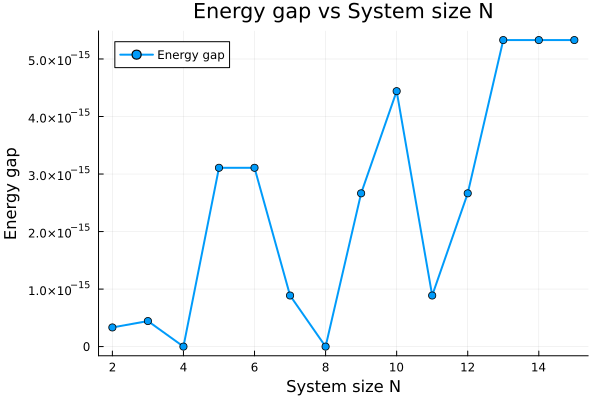

In [56]:
plot(system_sizes, gap_energies, xlabel="System size N", ylabel="Energy gap", title="Energy gap vs System size N", label="Energy gap", linewidth=2, marker=:circle)